In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the data
file_path = '/content/drive/MyDrive/Fall\'24/CS506/FinalProject/TMDB_cleaned.csv'
movies_df = pd.read_csv(file_path)
print("Data loaded successfully. Shape:", movies_df.shape)

class WeatherMLRecommender:
    def __init__(self, movies_df):
        self.movies_df = movies_df
        self.scaler = StandardScaler()

    def prepare_features(self):
        """Prepare features for ML models"""
        # Create feature matrix
        feature_cols = [
            'vote_average', 'vote_count', 'popularity', 'runtime',
            'genre_action', 'genre_animation', 'genre_comedy',
            'genre_drama', 'genre_family', 'genre_fantasy',
            'genre_horror', 'genre_mystery', 'genre_romance',
            'genre_science_fiction', 'genre_thriller'
        ]

        # Ensure all feature columns exist
        for col in feature_cols:
            if col not in self.movies_df.columns:
                print(f"Warning: {col} not found in dataset. Creating dummy column.")
                self.movies_df[col] = 0

        # Scale features
        X = self.scaler.fit_transform(self.movies_df[feature_cols])
        return X

    def train_clustering_model(self, n_clusters=5):
        """
        Model 1: K-Means Clustering
        Groups movies into weather-appropriate clusters
        """
        X = self.prepare_features()

        # Train KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.movies_df['cluster'] = kmeans.fit_predict(X)

        # Define weather-cluster mappings
        self.weather_clusters = {
            'sunny': [0, 2],  # Clusters with upbeat, adventure movies
            'rainy': [1, 4],  # Clusters with drama, mystery movies
            'stormy': [3]     # Cluster with intense, thriller movies
        }

        return kmeans

    def train_collaborative_model(self):
        """
        Model 2: Nearest Neighbors Collaborative Filtering
        Finds similar movies based on feature similarity
        """
        X = self.prepare_features()

        # Train NearestNeighbors
        nn_model = NearestNeighbors(n_neighbors=10, metric='cosine')
        nn_model.fit(X)
        self.nn_model = nn_model

        return nn_model

    def train_matrix_factorization(self):
        """
        Model 3: Non-negative Matrix Factorization
        Discovers latent features that can correspond to weather-appropriate patterns
        """
        # Create genre matrix
        genre_cols = [col for col in self.movies_df.columns if col.startswith('genre_')]
        X = self.movies_df[genre_cols].values

        # Train NMF
        nmf = NMF(n_components=10, random_state=42)
        self.weather_factors = nmf.fit_transform(X)

        # Define weather components
        self.weather_components = {
            'sunny': [0, 3],    # Components corresponding to upbeat genres
            'rainy': [1, 4],    # Components corresponding to dramatic genres
            'stormy': [2, 5]    # Components corresponding to intense genres
        }

        return nmf

    def get_recommendations(self, weather, n_recommendations=5):
        """Get recommendations based on weather using all three models"""

        if weather not in ['sunny', 'rainy', 'stormy']:
            raise ValueError("Weather must be one of: sunny, rainy, stormy")

        # Get recommendations from each model
        cluster_recs = self._get_cluster_recommendations(weather, n_recommendations)
        collab_recs = self._get_collaborative_recommendations(weather, n_recommendations)
        nmf_recs = self._get_nmf_recommendations(weather, n_recommendations)

        # Combine recommendations using ensemble approach
        all_recs = pd.concat([cluster_recs, collab_recs, nmf_recs])
        final_recs = all_recs.groupby(all_recs.index).size()

        # Return top recommendations that appeared in multiple models
        return self.movies_df.loc[final_recs.nlargest(n_recommendations).index]

    def _get_cluster_recommendations(self, weather, n):
        """Get recommendations from clustering model"""
        relevant_clusters = self.weather_clusters[weather]
        return self.movies_df[self.movies_df['cluster'].isin(relevant_clusters)]\
            .nlargest(n, 'vote_average')

    def _get_collaborative_recommendations(self, weather, n):
        """Get recommendations from collaborative filtering model"""
        # Get a representative movie for the weather
        if weather == 'sunny':
            condition = (self.movies_df['genre_comedy'] == 1) & (self.movies_df['genre_family'] == 1)
        elif weather == 'rainy':
            condition = (self.movies_df['genre_drama'] == 1) & (self.movies_df['genre_romance'] == 1)
        else:  # stormy
            condition = (self.movies_df['genre_thriller'] == 1) & (self.movies_df['genre_science_fiction'] == 1)

        seed_movie = self.movies_df[condition].nlargest(1, 'vote_average')
        if len(seed_movie) == 0:
            print(f"No seed movie found for {weather} weather. Using fallback.")
            seed_movie = self.movies_df.nlargest(1, 'vote_average')

        # Find similar movies
        distances, indices = self.nn_model.kneighbors(
            self.prepare_features()[seed_movie.index[0]].reshape(1, -1)
        )
        return self.movies_df.iloc[indices[0][:n]]

    def _get_nmf_recommendations(self, weather, n):
        """Get recommendations from NMF model"""
        components = self.weather_components[weather]
        scores = self.weather_factors[:, components].mean(axis=1)
        return self.movies_df.iloc[np.argsort(-scores)[:n]]

# Initialize and train the recommender
print("Initializing recommender...")
recommender = WeatherMLRecommender(movies_df)

print("Training clustering model...")
recommender.train_clustering_model()

print("Training collaborative filtering model...")
recommender.train_collaborative_model()

print("Training matrix factorization model...")
recommender.train_matrix_factorization()

# Get and display recommendations for each weather type
for weather in ['sunny', 'rainy', 'stormy']:
    print(f"\n=== {weather.title()} Weather Recommendations ===")
    recs = recommender.get_recommendations(weather)
    print(recs[['title', 'genres', 'vote_average', 'runtime']].to_string())

# Save the trained recommender to your Google Drive (optional)
import pickle
recommender_path = '/content/drive/MyDrive/Fall\'24/CS506/FinalProject/weather_recommender.pkl'
with open(recommender_path, 'wb') as f:
    pickle.dump(recommender, f)
print(f"\nRecommender saved to: {recommender_path}")

Mounted at /content/drive
Data loaded successfully. Shape: (1021716, 56)
Initializing recommender...
Training clustering model...
Training collaborative filtering model...
Training matrix factorization model...


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(



=== Sunny Weather Recommendations ===
                                                                             title                                                                             genres  vote_average  runtime
12895                                Codename: Kids Next Door - Operation Z.E.R.O.  Animation, Science Fiction, TV Movie, Adventure, Family, Comedy, Fantasy, Mystery         7.965       73
19098                                               Marvel Rising: Secret Warriors            Family, Animation, Action, Comedy, Science Fiction, TV Movie, Adventure         6.800       80
29397                           What's New Scooby-Doo? Vol. 4: Merry Scary Holiday                                 Animation, Comedy, Science Fiction, Action, Family        10.000       85
32093  The 1st 13th Annual Fancy Anvil Awards Show Program Special: Live in Stereo                                                          Animation, Family, Comedy        10.000      120
39427           

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data and model...
Loading complete!
Generating visualizations...

Plotting genre distribution...


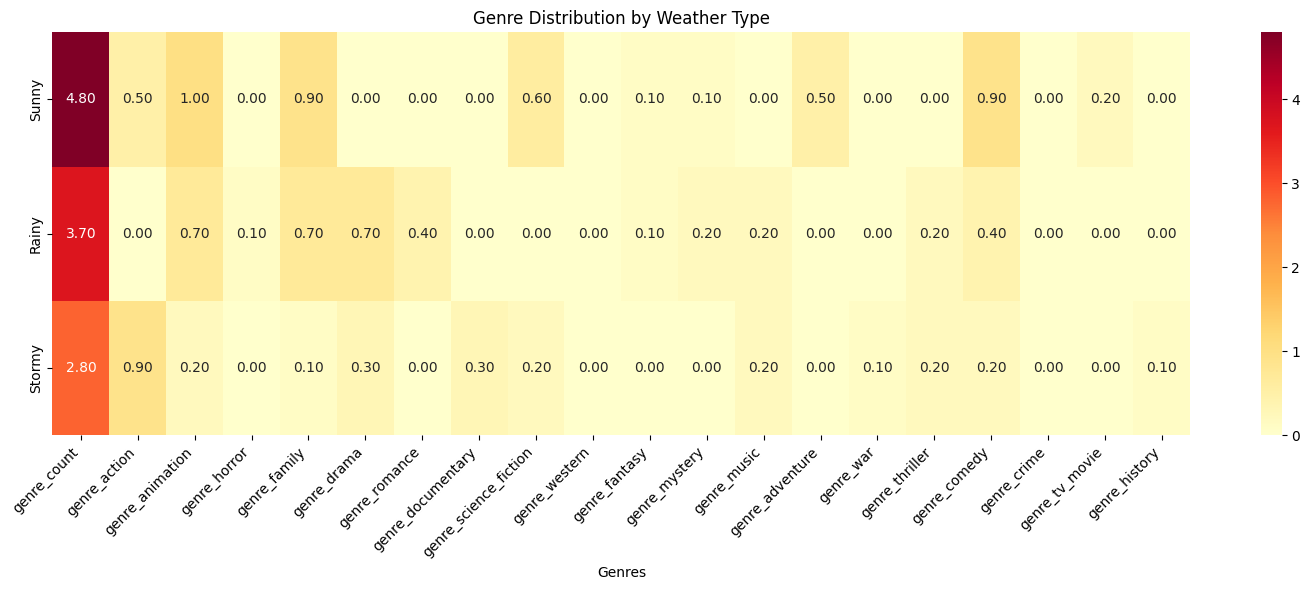


Plotting rating and runtime distributions...


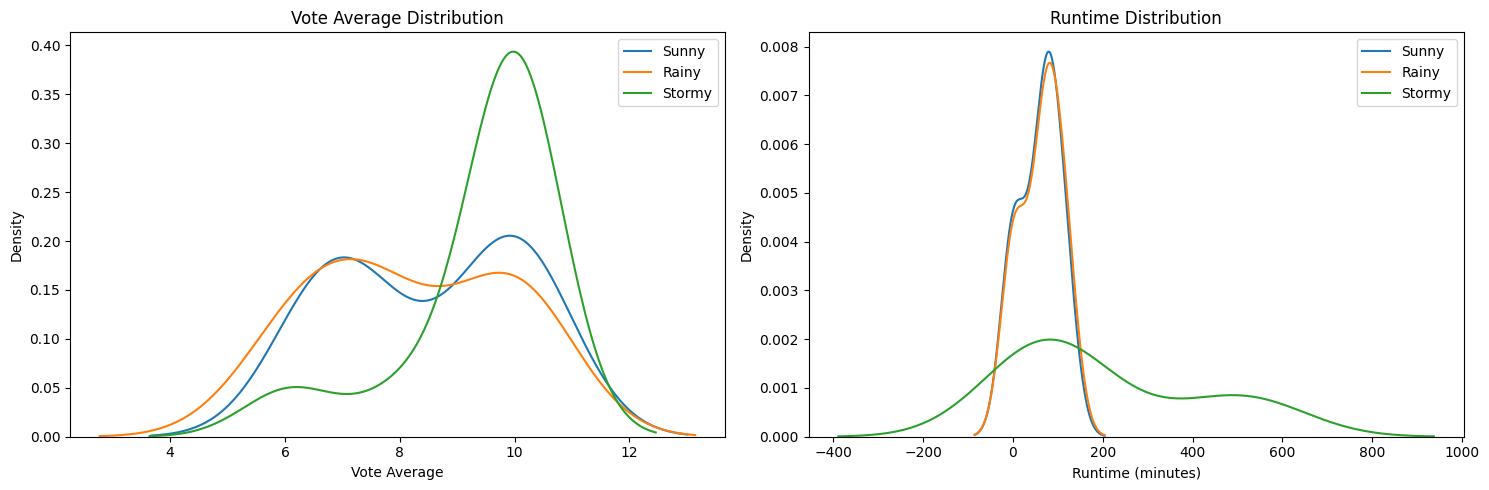


Creating interactive 3D visualization...


<ipython-input-4-b5120017fc97>:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-b5120017fc97>:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-b5120017fc97>:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Plotting popularity comparison...


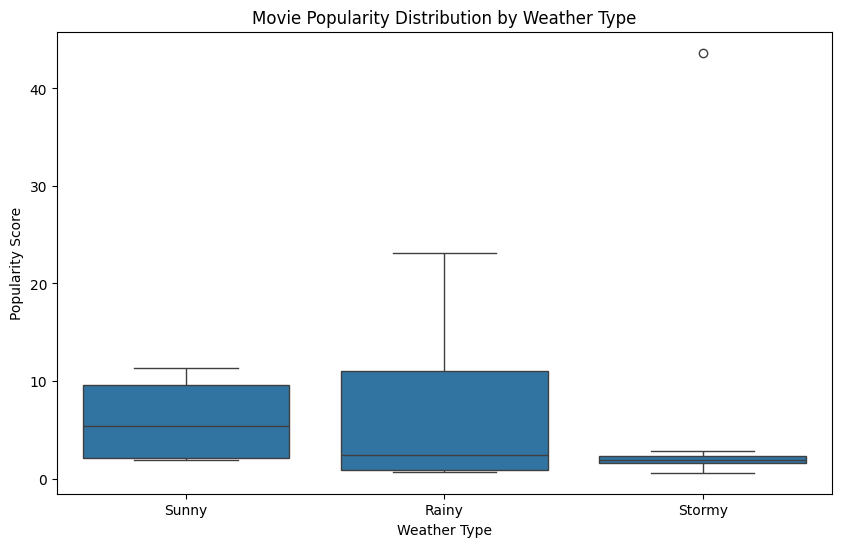

Visualization complete!

Visualizations saved to: /content/drive/MyDrive/Fall'24/CS506/FinalProject/visualizations


<Figure size 640x480 with 0 Axes>

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go

# Load the saved model and data
model_path = '/content/drive/MyDrive/Fall\'24/CS506/FinalProject/weather_recommender.pkl'
data_path = '/content/drive/MyDrive/Fall\'24/CS506/FinalProject/TMDB_cleaned.csv'

# Load the data and model
print("Loading data and model...")
movies_df = pd.read_csv(data_path)
with open(model_path, 'rb') as f:
    recommender = pickle.load(f)
print("Loading complete!")

def create_weather_visualizations():
    """Create comprehensive visualizations for the weather recommender"""
    weather_types = ['sunny', 'rainy', 'stormy']

    # Get recommendations for each weather type
    all_recs = {}
    for weather in weather_types:
        try:
            recs = recommender.get_recommendations(weather, 10)
            all_recs[weather] = recs
        except Exception as e:
            print(f"Error getting recommendations for {weather}: {str(e)}")
            return

    # 1. Plot Genre Distribution
    def plot_genre_distribution():
        plt.figure(figsize=(15, 6))
        genre_cols = [col for col in movies_df.columns if col.startswith('genre_')]

        genre_data = pd.DataFrame()
        for weather in weather_types:
            genre_means = all_recs[weather][genre_cols].mean()
            genre_data[weather.title()] = genre_means

        sns.heatmap(genre_data.T, annot=True, fmt='.2f', cmap='YlOrRd')
        plt.title('Genre Distribution by Weather Type')
        plt.xlabel('Genres')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # 2. Plot Rating and Runtime Distribution
    def plot_distributions():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Vote Average Distribution
        for weather in weather_types:
            sns.kdeplot(data=all_recs[weather]['vote_average'],
                       label=weather.title(), ax=ax1)
        ax1.set_title('Vote Average Distribution')
        ax1.set_xlabel('Vote Average')
        ax1.legend()

        # Runtime Distribution
        for weather in weather_types:
            sns.kdeplot(data=all_recs[weather]['runtime'],
                       label=weather.title(), ax=ax2)
        ax2.set_title('Runtime Distribution')
        ax2.set_xlabel('Runtime (minutes)')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    # 3. Plot Interactive Recommendation Visualization
    def plot_interactive_viz():
        df_viz = pd.DataFrame()
        for weather in weather_types:
            temp_df = all_recs[weather][['title', 'vote_average', 'popularity', 'runtime']]
            temp_df['weather_type'] = weather.title()
            df_viz = pd.concat([df_viz, temp_df])

        fig = px.scatter_3d(
            df_viz,
            x='vote_average',
            y='popularity',
            z='runtime',
            color='weather_type',
            hover_data=['title'],
            title='3D Visualization of Movie Recommendations',
            labels={
                'vote_average': 'Vote Average',
                'popularity': 'Popularity',
                'runtime': 'Runtime (minutes)',
                'weather_type': 'Weather Type'
            }
        )
        fig.show()

    # 4. Plot Popularity Comparison
    def plot_popularity():
        plt.figure(figsize=(10, 6))
        popularity_data = []
        labels = []

        for weather in weather_types:
            popularity_data.extend(all_recs[weather]['popularity'].values)
            labels.extend([weather.title()] * len(all_recs[weather]))

        sns.boxplot(x=labels, y=popularity_data)
        plt.title('Movie Popularity Distribution by Weather Type')
        plt.xlabel('Weather Type')
        plt.ylabel('Popularity Score')
        plt.show()

    # Generate all visualizations
    print("\nPlotting genre distribution...")
    plot_genre_distribution()

    print("\nPlotting rating and runtime distributions...")
    plot_distributions()

    print("\nCreating interactive 3D visualization...")
    plot_interactive_viz()

    print("\nPlotting popularity comparison...")
    plot_popularity()

# Run the visualizations
print("Generating visualizations...")
create_weather_visualizations()
print("Visualization complete!")

# Optional: Save current figure to Drive
save_path = '/content/drive/MyDrive/Fall\'24/CS506/FinalProject/visualizations'
try:
    plt.savefig(f'{save_path}/weather_recommendations_analysis.png')
    print(f"\nVisualizations saved to: {save_path}")
except Exception as e:
    print(f"Note: Couldn't save visualizations to file: {str(e)}")